# Victoria Airbnb analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from plotnine import *
import warnings
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15,10)

## 1. Business understanding

This project is trying to answer the following busienss questions: 

1. What Victoria neighborhood has the most listings?
2. What is the most popular neighborhood according to reviews?
3. What is the best time of year to visit Victoria?
4. What amenities are the most common? Are they differ across neighborhoods?
5. Can we predict price of a new listing?


## 2. Data Understanding

In [56]:
# Define helper functions for eda and data cleansing

def clean_date(date_col):
    '''Clean date cols'''
    return date_col.astype(np.datetime64)

def clean_currency(curr_col):
    '''Clean currency formated columns'''
    return curr_col.replace('[\$,]','',regex=True).astype('float64')

def clean_bool(bool_col):
    '''Clean boolean col'''
    return bool_col.replace({'t':True,'f':False})

def find_col_contains(df,string):
    '''Find columns contains string in a dataframe, return a dataframe with those columns'''
    return df[df.columns[df.columns.str.contains(string)]]

def profile_data(df,unique_no = 5, first_n_char = 10):
    '''
    Profile a dataframe, showing column name, no of unique values, and its unique values
    with limited character for readability. 
    
    '''
    for col in df.columns:
        nuniques = df[col].nunique()
        unique_vals = [str(val)[:first_n_char] for val in df[col].unique()[:unique_no]]
        print(col," (",nuniques,'): ',unique_vals ,sep='')

def drop_columns(df,cols):
    '''Drop multiple columns at once'''
    for col in cols:
        df.drop(col,axis=1,inplace=True)

### 2.1 Listings

In [32]:
# Get and preview listings data file 
listings = pd.read_csv('../data/victoria/listings.csv')
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1591,https://www.airbnb.com/rooms/1591,20190526203453,2019-05-26,Garden Suite-King-Ensuite,Relax and unwind at Abbeymoore Manor perfectly...,"Enjoy the charm, privacy and luxury of a self-...",Relax and unwind at Abbeymoore Manor perfectly...,none,Welcome to Abbeymoore Manor Abbeymoore is idea...,...,t,f,strict_14_with_grace_period,f,f,8,1,7,0,NaN
1,12125,https://www.airbnb.com/rooms/12125,20190526203453,2019-05-26,Mermaid's Rest Guesthouse,This cozy home is not available for short term...,Welcome to my unique cottage in the trees in M...,This cozy home is not available for short term...,none,NaN,...,f,f,moderate,f,f,2,1,1,0,0.25
2,14560,https://www.airbnb.com/rooms/14560,20190526203453,2019-05-26,"Close to Royal Roads, hiking & biking trails",Welcome to Royal Roads Suite at Latoria Walk. ...,Since we started listing on and off throughout...,Welcome to Royal Roads Suite at Latoria Walk. ...,none,There are many lovely hiking/walking trails ri...,...,f,f,moderate,t,t,1,1,0,0,0.49
3,18101,https://www.airbnb.com/rooms/18101,20190526203453,2019-05-26,Victorian Suite,NaN,When you enter this gracious room on the secon...,When you enter this gracious room on the secon...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,4,0,4,0,NaN
4,18103,https://www.airbnb.com/rooms/18103,20190526203453,2019-05-26,Boudoir,NaN,Calm blue and white greets you in this romanti...,Calm blue and white greets you in this romanti...,none,NaN,...,t,f,strict_14_with_grace_period,f,f,4,0,4,0,NaN


In [33]:
listings.shape

(3655, 106)

In [35]:
listings.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,3655,NaN,NaN,NaN,1.95994e+07,9.78107e+06,1591,1.28642e+07,2.00902e+07,2.76205e+07,3.50731e+07
listing_url,3655,3655,https://www.airbnb.com/rooms/13130123,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scrape_id,3655,NaN,NaN,NaN,2.01905e+13,0,2.01905e+13,2.01905e+13,2.01905e+13,2.01905e+13,2.01905e+13
last_scraped,3655,1,2019-05-26,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name,3654,3629,起点家庭旅馆,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary,3562,3440,All applicable taxes are included in the manag...,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
space,2964,2859,Outdoor smoking area - Rooftop BBQ common area,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,3631,3577,"Welcome to the Cottages at Portage West, a par...",8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
experiences_offered,3655,1,none,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighborhood_overview,2659,2395,"The immediate area offers: Elements Casino, Ro...",22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# Value counts by missing percentage 
pd.cut((listings.isna().sum()/listings.shape[0]),[-np.Inf,.25,.5,.75,1]).value_counts()

(-inf, 0.25]    89
(0.75, 1.0]     10
(0.25, 0.5]      7
(0.5, 0.75]      0
dtype: int64

In [55]:
# columns with long text len
listings.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
summary                                          object
space                                            object
description                                      object
experiences_offered                              object
neighborhood_overview                            object
notes                                            object
transit                                          object
access                                           object
interaction                                      object
house_rules                                      object
thumbnail_url                                   float64
medium_url                                      float64
picture_url                                     

In [57]:
profile_data(listings)

id (3655): ['1591', '12125', '14560', '18101', '18103']
listing_url (3655): ['https://ww', 'https://ww', 'https://ww', 'https://ww', 'https://ww']
scrape_id (1): ['2019052620']
last_scraped (1): ['2019-05-26']
name (3629): ['Garden Sui', "Mermaid's ", 'Close to R', 'Victorian ', 'Boudoir']
summary (3440): ['Relax and ', 'This cozy ', 'Welcome to', 'nan', 'Perfect Do']
space (2859): ['Enjoy the ', 'Welcome to', 'Since we s', 'When you e', 'Calm blue ']
description (3577): ['Relax and ', 'This cozy ', 'Welcome to', 'When you e', 'Calm blue ']
experiences_offered (1): ['none']
neighborhood_overview (2395): ['Welcome to', 'nan', 'There are ', 'The "Astor', 'Our proper']
notes (1898): ['If you wou', 'nan', 'If you wis', 'See calend', 'Salt Sprin']
transit (2334): ['There are ', 'I recommen', 'Bus #59 Tr', 'nan', 'Public tra']
access (2314): ['We have 5 ', 'You will h', 'Wifi, Sams', 'nan', 'The condo ']
interaction (2322): ['Welcome fr', 'nan', 'We live ab', 'We meet al', 'Hosts, Cel']
hous

We can observer the following about the listings data:
* The data is listing data with information about the listing
* There are 106 features with 3,655 observations
* The data we downloaded are in CSV (comma separated) format, which does not preserve data types. Data types like dates has to be dealt with manually
* The data is likely scraped directly from AirBnB website, so some currency fields (price, security_deposit, cleaning_fee…), boolean fields (instant_bookable, host_is_super_host…) have to be reformatted
* There are columns with no data or mostly missing data
* The price column has some outliers than can potentially skew our analysis
* Amenities column is nested and need to be flattened.
* ong text object will be turn into null or not null to feed in ML model later


### 2.2 Calendar data

In [58]:
# Get and preview calendar data file 
calendar = pd.read_csv('../data/victoria/calendar.csv')
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,910427,2019-05-26,f,$88.00,$88.00,2,29
1,2060849,2019-05-26,f,$150.00,$150.00,7,1125
2,2060849,2019-05-27,f,$150.00,$150.00,7,1125
3,2060849,2019-05-28,f,$150.00,$150.00,7,1125
4,2060849,2019-05-29,f,$150.00,$150.00,7,1125


In [59]:
calendar.shape

(1334075, 7)

In [61]:
calendar.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
listing_id,1.33408e+06,NaN,NaN,NaN,1.95994e+07,9.77974e+06,1591,1.28565e+07,2.00902e+07,2.76274e+07,3.50731e+07
date,1334075,365,2020-01-08,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
available,1334075,2,f,761246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1334075,699,$150.00,41980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adjusted_price,1334075,701,$150.00,41571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minimum_nights,1.33408e+06,NaN,NaN,NaN,5.05256,13.5316,1,1,2,3,365
maximum_nights,1.33408e+06,NaN,NaN,NaN,623.353,529.978,1,30,1125,1125,1499


In [63]:
calendar.isna().sum()

listing_id        0
date              0
available         0
price             0
adjusted_price    0
minimum_nights    0
maximum_nights    0
dtype: int64

In [64]:
calendar.dtypes

listing_id         int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights     int64
maximum_nights     int64
dtype: object

In [65]:
profile_data(calendar)

listing_id (3655): ['910427', '2060849', '1591', '920656', '12125']
date (365): ['2019-05-26', '2019-05-27', '2019-05-28', '2019-05-29', '2019-05-30']
available (2): ['f', 't']
price (699): ['$88.00', '$150.00', '$279.00', '$309.00', '$136.00']
adjusted_price (701): ['$88.00', '$150.00', '$279.00', '$309.00', '$136.00']
minimum_nights (41): ['2', '7', '14', '1', '3']
maximum_nights (105): ['29', '1125', '356', '1124', '60']


We can observe the following about calendar dataset: 
* The data is availibility for listings data with corresponding price
* There are 1.3 million observations
* Date and currency is formatted wrong
* There is no missing data

### 2.3 Reviews data

In [66]:
# Get and preview calendar data file 
reviews = pd.read_csv('../data/victoria/reviews.csv')
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,12125,248623,2011-05-02,521712,Trevor,Accommodations were comfortable. We appreciate...
1,12125,4383815,2013-05-01,81092,Mark,Only met Kelly -Anne briefly but she came well...
2,12125,5647488,2013-07-09,1488420,Lauriane,Our stay in Kelly-Ann's place has been wonderf...
3,12125,6927326,2013-08-30,8349475,Lucie,Our trip to North Pender Island was so peacefu...
4,12125,9024688,2013-12-02,9604544,Leslie,I judge vacation rentals by kitchen knives. If...


In [67]:
reviews.shape

(138520, 6)

In [69]:
reviews.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
listing_id,138520,NaN,NaN,NaN,1.36377e+07,8.37063e+06,12125,6.04503e+06,1.39147e+07,1.96123e+07,3.50132e+07
id,138520,NaN,NaN,NaN,2.40727e+08,1.20919e+08,248623,1.5166e+08,2.54438e+08,3.24336e+08,4.59011e+08
date,138520,2363,2019-05-20,508,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewer_id,138520,NaN,NaN,NaN,7.49981e+07,6.66162e+07,46,1.88911e+07,5.43968e+07,1.21153e+08,2.6392e+08
reviewer_name,138520,20424,David,1115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comments,138477,136284,.,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
profile_data(reviews)

listing_id (3118): ['12125', '14560', '54423', '83515', '121235']
id (138520): ['248623', '4383815', '5647488', '6927326', '9024688']
date (2363): ['2011-05-02', '2013-05-01', '2013-07-09', '2013-08-30', '2013-12-02']
reviewer_id (118030): ['521712', '81092', '1488420', '8349475', '9604544']
reviewer_name (20424): ['Trevor', 'Mark', 'Lauriane', 'Lucie', 'Leslie']
comments (136284): ['Accommodat', 'Only met K', 'Our stay i', 'Our trip t', 'I judge va']


We can observe the following about reviews dataset: 
* The data is reviews for listings
* There are more than 138K reviews
* Date is formatted wrong

## 3. Data prepartion
Based on the observations above, here are classes to:
* Define class and function to correctly format and clean data. 

* Load data to objects for further analysis and modelling

In [3]:
class airbnb_city_data:
    '''
    Create object to load, clean Kaggle AirBnB data.

    The datasets for this project can be downloaded here:
    http://insideairbnb.com/get-the-data.html

    Parameters:
    ------
    location: Pass in folder name location containing AirBnB data.
    data_dir: Optionally pass in directory to data folders
    '''
    def __init__(self, location = 'victoria', data_dir = '../data/'):
        self.location = location
        self.dir = data_dir
        self.listings = self.reviews = self.calendar = pd.DataFrame()


    def load_data(self):
        '''Load the data from file and store in the object'''
        files = ['listings','calendar','reviews']
        path = self.dir + self.location
        for file in files:
            df = pd.read_csv(path + '/' + file + '.csv')
            setattr(self,file,df)

    def clean_calendar(self):
        '''Clean calendar df'''
        self.calendar['location'] = self.location
        self.calendar.date = clean_date(self.calendar.date)
        self.calendar.price = clean_currency(self.calendar.price)
        self.calendar.available = clean_bool(self.calendar.available)

    def clean_reviews(self):
        '''Clean reviews df'''
        self.reviews['location'] = self.location
        self.reviews.date = clean_date(self.reviews.date)

    def clean_listings(self):
        '''Clean listings df'''
        self.listings['location'] = self.location
        
        #Clean boolean cols
        bool_cols = self.listings.columns[self.listings.isin(['t','f']).mean() > 0]
        for col in bool_cols:
            self.listings[col] = clean_bool(self.listings[col])
        #Clean currency cols
        curr_cols = (self.listings.iloc[self.listings.isna().sum(axis=1).idxmin()].
                     str.startswith('$').fillna(False)[lambda x: x].index)
        for col in curr_cols:
            self.listings[col] = clean_currency(self.listings[col])
        #Clean date cols
        for k,v in self.listings.iloc[self.listings.isna().sum(axis=1).idxmin()].items():
            if re.match('[0-9]{4}\-[0-9]{1,2}\-[0-9]{1,2}',str(v)) != None:
                self.listings[k] = clean_date(self.listings[k])
        #Remove outliers listing
        threshold = self.listings.price.quantile(0.99)
        self.listings.price = self.listings.price[lambda x: x<threshold]
        self.listings.dropna(subset=['price'],inplace=True)
        
        #Flatten ammenities column
        self.listings['amenities'] = (self.listings.amenities.replace('[{}"]','',regex=True).
                                      apply(lambda x: x.split(',')).pipe(pd.DataFrame))
        
        mlb = MultiLabelBinarizer()
        self.listings = self.listings.join(pd.DataFrame(mlb.fit_transform(self.listings.pop('amenities')),
                                              columns='amen_'+mlb.classes_,index = self.listings.index).
                                           astype('bool'))
        
        #Turn long text column to boolean (null or not null)
        long_text_cols = (self.listings.select_dtypes('object').
                          apply(lambda x: x.str.len().mean())[lambda x: x>30].index)
        long_text_df = self.listings.copy()[long_text_cols]
        drop_columns(self.listings, long_text_cols)
        long_text_df.columns = 'has_' + long_text_df.columns
        long_text_df = long_text_df.notnull()
        self.listings = self.listings.join(long_text_df)
        
        #Drop all NA cols
        #na_cols = self.listings.columns[self.listings.isna().sum() == self.listings.shape[0]]
        na_cols = self.listings.columns[self.listings.nunique() == 1]
        drop_columns(self.listings, na_cols)
        
        #Drop columns with more than 50% missing data
        missing_cols = (self.listings.isnull().sum()/self.listings.shape[0])[lambda x: x>.5].index
        drop_columns(self.listings,missing_cols)

        
    def init(self):
        '''Load, clean data, load them to objects for further analysis '''
        self.load_data()
        self.clean_calendar()
        self.clean_reviews()
        self.clean_listings()
        return self.listings, self.calendar, self.reviews

In [4]:
# Initialize object and load data
vic = airbnb_city_data()
listings, calendar, reviews = vic.init()

## 4. Answering business questions

### Question 1: What Victoria neighborhood has the most listings? 

In [10]:
# Count listing group by neighbourhood, calculate % of total
nbh = listings.pivot_table('id',['neighbourhood_cleansed','neighbourhood_group_cleansed'],
                           aggfunc=['count', lambda x: x.count()/listings.shape[0]])
nbh = nbh.droplevel(1,axis=1)
nbh.columns = ['Listing count','% of total']
nbh.sort_values('% of total',ascending=False,inplace=True)
nbh['% of total'] = nbh['% of total'].apply(lambda x: '{0:.1%}'.format(x))
nbh.index.names = ['Neighbourhood','Neighbourhood group']
nbh.head()

,,Listing count,% of total
Neighbourhood,Neighbourhood group,,
Saanich,Saanich,720,19.9%
Downtown,Victoria,480,13.3%
Salt Spring Island,Salt Spring Island,318,8.8%
Langford,Langford,219,6.1%
Southern Gulf Islands,Southern Gulf Islands,189,5.2%


### Question 2: What is the most popular neighborhood according to reviews?

In [11]:
# Calculate review count by neighborhood and their average rating
nbhrv = listings.pivot_table(['number_of_reviews','review_scores_value'],
                             ['neighbourhood_cleansed','neighbourhood_group_cleansed'],
                     aggfunc={'number_of_reviews':'sum','review_scores_value':'mean'})

nbhrv.columns = ['Review count','Average rating']
nbhrv.index.names = ['Neighbourhood','Neighbourhood group']
nbhrv.sort_values('Review count',ascending=False,inplace=True)
nbhrv.head()

,,Review count,Average rating
Neighbourhood,Neighbourhood group,,
Downtown,Victoria,32750,9.624719
Saanich,Saanich,19142,9.591803
Salt Spring Island,Salt Spring Island,13391,9.652778
Southern Gulf Islands,Southern Gulf Islands,7881,9.703488
James Bay,Victoria,7652,9.620438


In [12]:
# Average rating in Victoria
listings.review_scores_value.mean()

9.660807291666666

### Question 3: What is the best time of year to visit Victoria? 

In [13]:
# Group by year, calculating review count
reviews.groupby(pd.Grouper(key='date',freq='Y')).id.count()

date
2011-12-31       31
2012-12-31      213
2013-12-31      811
2014-12-31     2606
2015-12-31     7443
2016-12-31    17062
2017-12-31    33450
2018-12-31    56476
2019-12-31    20428
Freq: A-DEC, Name: id, dtype: int64

In [14]:
# Filter relevant years only
rev = reviews[reviews.date.dt.year.isin([2016,2017,2018])]
rev['month'] = rev.date.dt.month

In [15]:
rev.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,location,month
22,12125,90844772,2016-08-02,4900810,Randy,Mermaid's Rest Guesthouse and our host Kelly-A...,victoria,8
23,12125,96304620,2016-08-22,27968223,Amanda,"Kelly-Ann was a great host, and her home is be...",victoria,8
24,12125,99797245,2016-09-06,30121945,Spencer,Nicest Cabin Ever! We all want to move it with...,victoria,9
50,14560,63783342,2016-02-27,5751535,Leanne,Elise was a wonderful host and the condo was t...,victoria,2
51,14560,86724866,2016-07-17,14392938,Dana,This condo was absolutely wonderful. It was we...,victoria,7


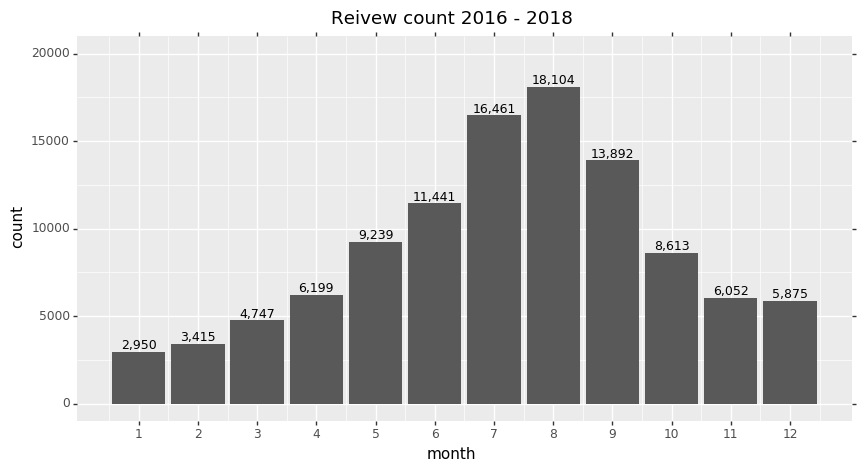

<ggplot: (332577288)>

In [16]:
# Plot review count from 2016 to 2018
(ggplot(rev,aes('month')) + geom_bar(stat='count') + ylim((0,20000)) + 
 geom_text(aes(label='stat(count)'),stat='count', va='bottom', size =9, format_string= "{:,d}") +
 theme(figure_size=(10,5)) + scale_x_continuous(breaks=range(1,13)) + ggtitle('Reivew count 2016 - 2018')
) 

In [17]:
# % of review count by month
rev.month.value_counts(normalize=True) * 100

8     16.921524
7     15.385838
9     12.984634
6     10.693723
5      8.635548
10     8.050436
4      5.794108
11     5.656709
12     5.491270
3      4.436946
2      3.191947
1      2.757319
Name: month, dtype: float64

In [18]:
# % of reivew count of top 4 months
(rev.month.value_counts(normalize=True) * 100).iloc[:4].sum()

55.985718024451344

### Question 4: What amenities are the most common? 


In [19]:
# Show top 10 common aminities 
amenities = find_col_contains(listings,'amen').sum()
amenities.sort_values(ascending=False).reset_index().head(10).rename({0:'count'},axis=1)

,index,count
0,amen_Wifi,3500
1,amen_Heating,3488
2,amen_Essentials,3467
3,amen_Smoke detector,3367
4,amen_Kitchen,3208
5,amen_Hangers,3175
6,amen_Free parking on premises,2888
7,amen_Shampoo,2885
8,amen_Hair dryer,2840
9,amen_TV,2809


### Question 5: Can we predict price of a new listing? 

## 5. Modeling

In [20]:
# Choose relevant columns that a new listing may have to prevent data leakage 
object_cols = ['neighbourhood_cleansed','property_type',
       'room_type', 'bed_type', 'cancellation_policy']
float_cols = ['latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'price' ]
bool_cols = ['instant_bookable',
       'has_neighborhood_overview', 'has_notes', 'has_transit', 'has_access',
       'has_interaction', 'has_house_rules', 'has_host_location',
       'has_host_about', 'has_host_thumbnail_url', 'has_host_picture_url',
       'has_jurisdiction_names']
int_cols = ['accommodates', 'guests_included', 'minimum_nights']

In [21]:
# Create training data df
training_data = listings[object_cols+float_cols+bool_cols + int_cols]

In [22]:
# Onehotencode categorical data, drop na values
training_data = training_data.join(pd.get_dummies(training_data[object_cols]))
training_data.drop(object_cols,axis=1,inplace=True)
training_data.dropna(axis=0,inplace=True)

In [23]:
# Define X, y
y = pd.DataFrame(training_data.pop('price'))
X = training_data

In [24]:
# Scale numerical columns
sc = StandardScaler()
numeric_cols = X.select_dtypes(['int64','float64']).columns

sc_transformed_cols = pd.DataFrame(sc.fit_transform(X[numeric_cols]), columns=numeric_cols, index = X.index)
X.drop(numeric_cols,axis=1,inplace=True)
X = X.merge(sc_transformed_cols,left_index= True, right_index = True, how='left')

In [25]:
# Split train test df
X_train,X_test,y_train,y_test =train_test_split(X,y)

In [26]:
# Define models
models = ['SGDRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 
          'BaggingRegressor', 'GradientBoostingRegressor']

## 6. Evaluation

In [27]:
# Fit, train, evaluate models 
scores = {}
for model in models: 
    globals()[model] = eval(model + '()')
    globals()[model].fit(X_train,y_train)
    score = globals()[model].score(X_test,y_test)
    scores[model] = score
scores

{'SGDRegressor': 0.5401739038708594,
 'RandomForestRegressor': 0.5501721631389632,
 'AdaBoostRegressor': 0.1985543893899506,
 'BaggingRegressor': 0.5384129810516732,
 'GradientBoostingRegressor': 0.5798992766738473}

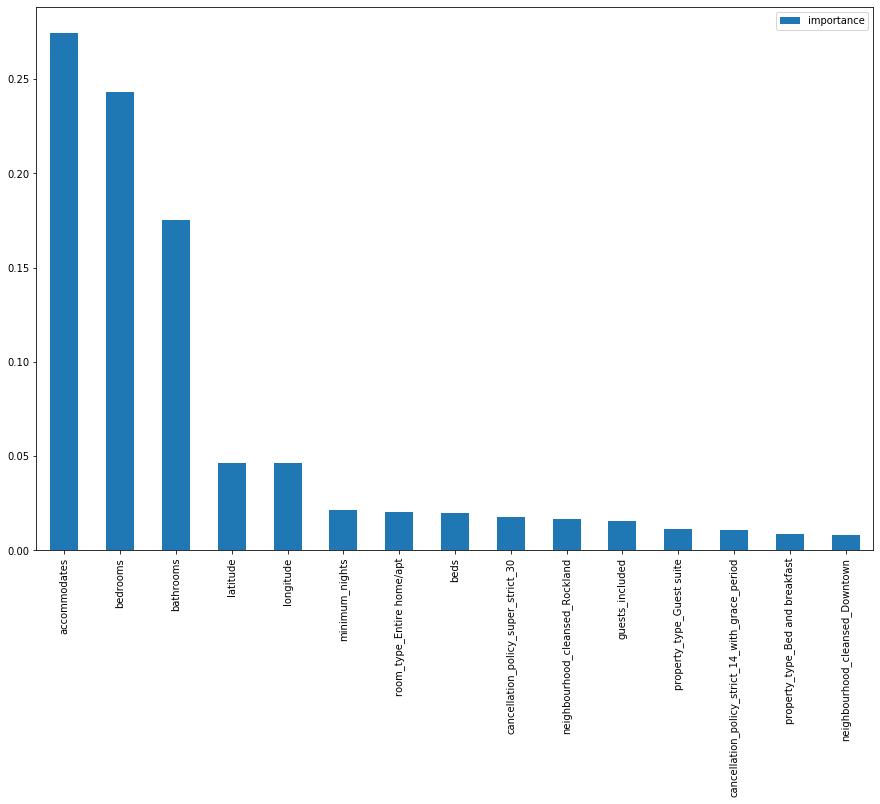

In [28]:
# Visualize feature importance for the best model
feature_importances = pd.DataFrame(GradientBoostingRegressor.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.sort_values('importance',ascending=False).head(15).plot(kind='bar',figsize=(15,10))

## 7. Deployment
For this project, I will stop here. What we can do next is:
* Try engineering new features for our models.
* Try tuning hyperparameters of the models to improve its accuracy.
* Try deploy machine learning models
* Try answering other questions using the data.